In [26]:
#模型选择，过拟合和欠拟合
import math
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #设置选项允许重复加载动态链接库。



In [27]:
#使用三阶多项式来生成训练和测试数据的标签：
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])    #生成一个20维的向量，只有前面4个元素有值，其他都是0

features = np.random.normal(size=(n_train + n_test, 1))#标准正态分布（μ=0,σ=1），对应于np.random.normal(loc=0, scale=1, size)
np.random.shuffle(features)  #随机排序
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))#np.power--
#numpy.power(x1, x2)数组的元素分别求n次方。x2可以是数字，也可以是数组，但是x1和x2的列数要相同。


In [28]:
np.arange(max_degree).reshape(1, -1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [29]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)   #np.dot矩阵乘法
labels += np.random.normal(scale=0.1, size=labels.shape)

In [30]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7443],
         [-0.5916]]),
 tensor([[ 1.0000e+00, -7.4430e-01,  2.7699e-01, -6.8721e-02,  1.2787e-02,
          -1.9035e-03,  2.3613e-04, -2.5107e-05,  2.3359e-06, -1.9317e-07,
           1.4378e-08, -9.7286e-10,  6.0341e-11, -3.4548e-12,  1.8367e-13,
          -9.1136e-15,  4.2395e-16, -1.8561e-17,  7.6751e-19, -3.0066e-20],
         [ 1.0000e+00, -5.9159e-01,  1.7499e-01, -3.4508e-02,  5.1037e-03,
          -6.0386e-04,  5.9540e-05, -5.0319e-06,  3.7211e-07, -2.4460e-08,
           1.4470e-09, -7.7822e-11,  3.8366e-12, -1.7459e-13,  7.3777e-15,
          -2.9097e-16,  1.0759e-17, -3.7440e-19,  1.2305e-20, -3.8314e-22]]),
 tensor([2.6688, 3.7464]))

In [31]:
#实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [32]:
#定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]   #shape[-1]代表最后一个维度
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))   #容器里只放一个简单的线性回归网络
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.022328   1.2123953 -3.4020877  5.5987906]]


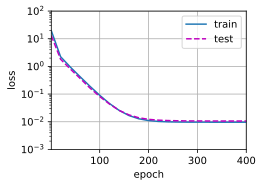

In [33]:
#三阶多项式函数拟合（正态）
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.61666  3.865831]]


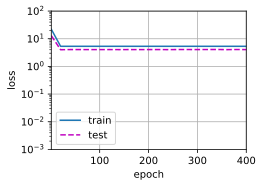

In [34]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.997455    1.2348275  -3.2328503   5.397445   -0.58851045  1.0775224
  -0.24925315  0.13877521 -0.19388172  0.09383395  0.01423132  0.10821968
  -0.04444835 -0.03188594 -0.17444049 -0.02460718  0.18328956  0.14919814
  -0.07719276  0.18687579]]


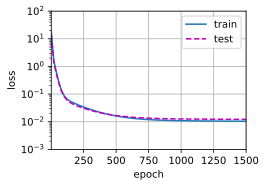

: 

In [35]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)